In [1]:
from landscapes import *
import os
import os.path as osp
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [19]:
import gudhi
# import gudhi.bottleneck

gudhi.bottleneck_distance(np.array([[1,2], [2,np.inf], [1.5, np.inf]]), np.array([[1,2], [1,np.inf]]))

inf

In [7]:
def Laplacian_fun(B22_st, B22_stm1, B22_sm1t, B22_sm1tm1, eye):
    # return B22_stm1@B22_sm1t@(eye-B22_st)@B22_sm1t
    # return B22_sm1t@(eye-B22_st)@B22_sm1t@B22_stm1
    # return B22_sm1t@B22_stm1@(eye-B22_st)@B22_stm1
    # return B22_stm1@(eye-B22_st)@B22_stm1@B22_sm1t
    # return B22_sm1tm1-B22_sm1t-B22_stm1+B22_st

    
    # return B22_stm1@B22_sm1t+B22_sm1t@B22_stm1-2*B22_st
    # return eye-B22_st

    # return B22_stm1@(eye-B22_st)@(eye - B22_sm1tm1 + B22_sm1t)

    # Best
    # return B22_sm1t@B22_stm1-B22_st

    # Normal
    return B22_stm1 - B22_st - B22_sm1tm1 + B22_sm1t

LANDSCAPES
----------------

In [3]:
class LandscapeLoader():
    def __init__(self, path_to_landscapes, path_to_landscapes_mtilde, epsilons, min_image_i = 0, max_image_i=np.inf):
        self.path_to_landscapes = path_to_landscapes
        self.path_to_landscapes_mtilde = path_to_landscapes_mtilde
        self.epsilons = epsilons
        

        self.location_dict = {}
        self.location_pointers = {}
        for eps in epsilons:
            path_to_landscapes = osp.join(self.path_to_landscapes, f"eps_{eps}")
            path_to_landscapes_mtilde = osp.join(self.path_to_landscapes_mtilde, f"eps_{eps}")
            self.location_dict[eps] = {}
            self.location_pointers[eps] = {}
            for color in sorted(os.listdir(path_to_landscapes)):
                self.location_dict[eps][color] = {}
                self.location_pointers[eps][color] = {}
                for method in sorted(os.listdir(osp.join(path_to_landscapes, color))):
                    self.location_dict[eps][color][method] = {"laplacian": [], "normal": [], "mtilde": []}
                    self.location_pointers[eps][color][method] = {"laplacian": 0, "normal": 0, "mtilde": 0}
                    for land_file in tqdm(sorted(os.listdir(osp.join(path_to_landscapes, color, method))), leave=False, desc=f"Processing eps {eps}, {color} {method} landscapes"):
                        if not land_file.endswith(".pkl"):
                            continue
                        image_i = int(land_file[:-4].split("_")[-1])
                        if image_i < min_image_i or image_i >= max_image_i:
                            continue
                        self.location_dict[eps][color][method][land_file.split("_")[0]].append(osp.join(path_to_landscapes, color, method, land_file))
                        # with open(osp.join(path_to_landscapes, color, digit, land_file), "rb") as f:
                        #     land = pickle.load(f)
                        # if land_file.split("_")[0] == "pers":
                        #     land_dict[eps][color][digit][land_file.split("_")[0]].append(land.__mult__(1))
                        # else:
                        #     land_dict[eps][color][digit][land_file.split("_")[0]].append(land.__mult__(1))
                    for land_file in tqdm(sorted(os.listdir(osp.join(path_to_landscapes_mtilde, color, method))), leave=False, desc=f"Processing eps {eps}, {color} {method} mtilde landscapes"):
                        if not land_file.endswith(".pkl") or land_file.split("_")[0] == "normal":
                            continue
                        image_i = int(land_file[:-4].split("_")[-1])
                        if image_i < min_image_i or image_i >= max_image_i:
                            continue
                        self.location_dict[eps][color][method]["mtilde"].append(osp.join(path_to_landscapes_mtilde, color, method, land_file))
    def reset_pointer(self, eps_list=None, color_list=None, method_list=None, type_list=None):
        if eps_list is None:
            epss = self.location_pointers.keys()
        else:
            epss = eps_list
        for eps in epss:
            if color_list is None:
                colors = self.location_pointers[eps].keys()
            else:
                colors = color_list
            for color in colors:
                if method_list is None:
                    methods = self.location_pointers[eps][color].keys()
                else:
                    methods = method_list
                for method in methods:
                    if type_list is None:
                        types = ["laplacian", "normal", "mtilde"]
                    else:
                        types = type_list
                    for type_ in types:
                        if type_ in self.location_pointers[eps][color][method]:
                            self.location_pointers[eps][color][method][type_] = 0
                        else:
                            print(f"Warning: Type {type_} not found in {eps}, {color}, {method}. Skipping reset for this type.")
                        # self.location_pointers[eps][color][digit]["pers"] = 0

    def load(self, eps, color, method, type_):
        if self.location_pointers[eps][color][method][type_] >= len(self.location_dict[eps][color][method][type_]):
            return None
        path = self.location_dict[eps][color][method][type_][self.location_pointers[eps][color][method][type_]]
        self.location_pointers[eps][color][method][type_] += 1
        with open(path, "rb") as f:
            land = pickle.load(f)
        return land#.__mult__(1) if type_ == "pers" else land

def plot_mean_landscape(LL, eps, color, method, type_, max_k = 3, limits = None, n_eval=1000, errorbar="sd"):
    LL.reset_pointer([eps], [color], [method], [type_])

    all_evaluations = {0: {k: np.array([]) for k in range(max_k)}, 1: {k: np.array([]) for k in range(max_k)}}
    count = 0

    print(f"Loading landscapes for eps={eps}, color={color}, method={method}, type={type_}")
    while True:
        print(f"Loading landscape {count}", end="\r")
        land = LL.load(eps, color, method, type_)
        if land is None:
            break
        max_t = land.max_t
        count += 1
        for q in range(2):
            for k in range(max_k):
                if k not in land.evaluations[q].keys():
                    all_evaluations[q][k] = np.append(all_evaluations[q][k], np.zeros(n_eval))
                else:
                    all_evaluations[q][k] = np.append(all_evaluations[q][k], land.evaluations[q][k])

    print()
    x_axis = np.array(list(np.linspace(0, max_t, n_eval))*count)

    fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
        
    for dim in range(0, 2):
        cur_ax = ax[dim]

        for k in range(max_k):
            # max_non_zero = len(self.evaluations[dim])
            # for i in range(len(self.evaluations[dim])-1, -1, -1):
            #     if self.evaluations[dim][k][i] != 0:
            #         max_non_zero = i+1
            #         break
            # ax[dim].plot(np.linspace(0, self.max_t, len(self.evaluations[dim][k]))[:max_non_zero], self.evaluations[dim][k][:max_non_zero], c={0: "b", 1: "r", 2: "g", 3: "y"}[dim])
            print("Plotting k =", k, "dim =", dim, end="\r")
            sns.lineplot(x=x_axis, y=all_evaluations[dim][k], ax=cur_ax, label=f"k={k}", errorbar=errorbar)
        
        if limits is not None:
            if isinstance(limits[0], list):
                if len(limits) > dim:
                    cur_ax.set_xlim(limits[dim][0], limits[dim][1])
                    cur_ax.set_ylim(limits[dim][2], limits[dim][3])
            else:
                cur_ax.set_xlim(limits[0], limits[1])
                cur_ax.set_ylim(limits[2], limits[3])
        cur_ax.legend()
        cur_ax.set_xlabel("t")
        cur_ax.set_ylabel("Landscape")
        if type_ != "normal":
            cur_ax.set_title(f"Lap Landscape dim {dim}")
        else:
            cur_ax.set_title(f"Landscape dim {dim}")
        # cur_ax.set_title(f"Lap Landscape dim {dim}")
    fig.tight_layout()
    return ax


def plot_difference_landscape(LL, eps, color, method, max_k = 3, limits = None, n_eval=1000, errorbar="sd"):
    LL.reset_pointer([eps], [color], [method], ["laplacian", "mtilde"])

    all_evaluations_laplacian = {0: {k: np.array([]) for k in range(max_k)}, 1: {k: np.array([]) for k in range(max_k)}}
    count = 0

    print(f"Loading landscapes for eps={eps}, color={color}, method={method}, type=laplacian")
    while True:
        print(f"Loading landscape {count}", end="\r")
        land = LL.load(eps, color, method, "laplacian")
        if land is None:
            break
        max_t = land.max_t
        count += 1
        for q in range(2):
            for k in range(max_k):
                if k not in land.evaluations[q].keys():
                    all_evaluations_laplacian[q][k] = np.append(all_evaluations_laplacian[q][k], np.zeros(n_eval))
                else:
                    all_evaluations_laplacian[q][k] = np.append(all_evaluations_laplacian[q][k], land.evaluations[q][k])

    print()

    all_evaluations_mtilde = {0: {k: np.array([]) for k in range(max_k)}, 1: {k: np.array([]) for k in range(max_k)}}
    count = 0

    print(f"Loading landscapes for eps={eps}, color={color}, method={method}, type=mtilde")
    while True:
        print(f"Loading landscape {count}", end="\r")
        land = LL.load(eps, color, method, "mtilde")
        if land is None:
            break
        count += 1
        max_t = land.max_t
        for q in range(2):
            for k in range(max_k):
                if k not in land.evaluations[q].keys():
                    all_evaluations_mtilde[q][k] = np.append(all_evaluations_mtilde[q][k], np.zeros(n_eval))
                else:
                    all_evaluations_mtilde[q][k] = np.append(all_evaluations_mtilde[q][k], land.evaluations[q][k])

    print()

    x_axis = np.array(list(np.linspace(0, max_t, n_eval))*count)

    fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
        
    for dim in range(0, 2):
        cur_ax = ax[dim]

        for k in range(max_k):
            # max_non_zero = len(self.evaluations[dim])
            # for i in range(len(self.evaluations[dim])-1, -1, -1):
            #     if self.evaluations[dim][k][i] != 0:
            #         max_non_zero = i+1
            #         break
            # ax[dim].plot(np.linspace(0, self.max_t, len(self.evaluations[dim][k]))[:max_non_zero], self.evaluations[dim][k][:max_non_zero], c={0: "b", 1: "r", 2: "g", 3: "y"}[dim])
            print("Plotting k =", k, "dim =", dim, end="\r")
            sns.lineplot(x=x_axis, y=(all_evaluations_mtilde[dim][k]-all_evaluations_laplacian[dim][k]), ax=cur_ax, label=f"k={k}", errorbar=errorbar)
        
        if limits is not None:
            if isinstance(limits[0], list):
                if len(limits) > dim:
                    cur_ax.set_xlim(limits[dim][0], limits[dim][1])
                    cur_ax.set_ylim(limits[dim][2], limits[dim][3])
            else:
                cur_ax.set_xlim(limits[0], limits[1])
                cur_ax.set_ylim(limits[2], limits[3])
        cur_ax.legend()
        cur_ax.set_xlabel("t")
        cur_ax.set_ylabel("Landscape")
        if type_ != "normal":
            cur_ax.set_title(f"Lap Landscape dim {dim}")
        else:
            cur_ax.set_title(f"Landscape dim {dim}")
        # cur_ax.set_title(f"Lap Landscape dim {dim}")
    fig.tight_layout()
    return ax


ALPHA FILTRATION
---------------------

In [28]:
LL_train_alpha = LandscapeLoader("../alpha_landscapes_normal_function/", "../alpha_landscapes/", [15], max_image_i=80)
LL_test_alpha = LandscapeLoader("../alpha_landscapes_normal_function/", "../alpha_landscapes/", [15], min_image_i=80)
LL_all_alpha = LandscapeLoader("../alpha_landscapes_normal_function/", "../alpha_landscapes/", [15], min_image_i=0, max_image_i=np.inf)

# LL_train_Mtilde_alpha = LandscapeLoader("../alpha_landscapes/", [15], max_image_i=80)
# LL_test_Mtilde_alpha = LandscapeLoader("../alpha_landscapes/", [15], min_image_i=80)

Processing eps 15, alpha HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, alpha HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, alpha PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, alpha HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, alpha PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, alpha HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, alpha PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Loading landscapes for eps=15, color=alpha, method=HC, type=laplacian
Loading landscape 97


array([<Axes: title={'center': 'Lap Landscape dim 0'}, xlabel='t', ylabel='Landscape'>,
       <Axes: title={'center': 'Lap Landscape dim 1'}, xlabel='t', ylabel='Landscape'>],
      dtype=object)

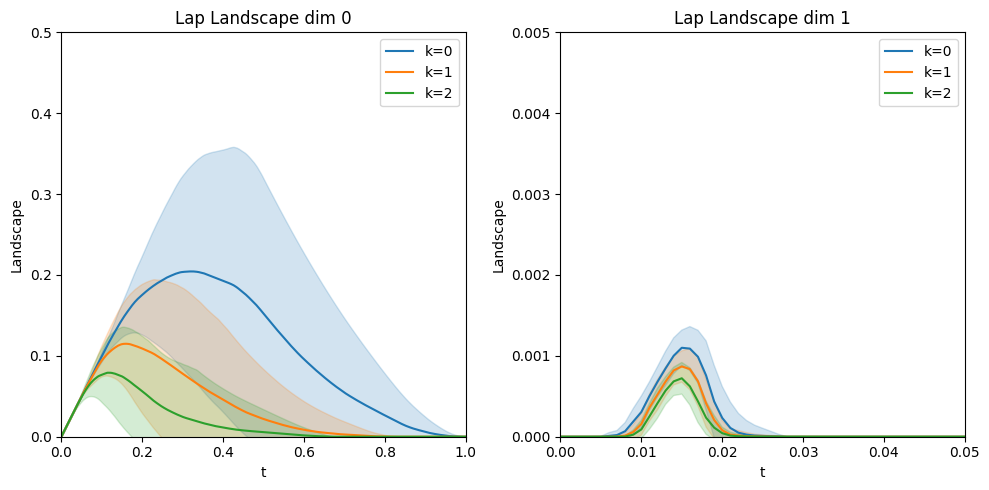

In [52]:
plot_mean_landscape(LL_all_alpha, 15, "alpha", "HC", "laplacian", limits = [[0,1,0,0.5], [0,0.05,0,0.005]])

In [ ]:
method_list = ["PV", "cluster", "HC"]
# out_dict_alpha = {"alpha": {}}

for type_ in ["mtilde", "normal", "laplacian"]:
    # out_dict_alpha["alpha"][type_] = {}
    for method in method_list:
        # out_dict_alpha["alpha"][type_][method] = {}

        print(f"Gathering statistics for {type_} landscapes with method {method}\n"+"-"*20)

        LL_all_alpha.reset_pointer()

        sum_land = LL_all_alpha.load(15, "alpha", method, type_)
        counter = 1

        while True:
            land = LL_all_alpha.load(15, "alpha", method, type_)
            if land is None:
                break
            counter += 1
            print(f"Loaded landscape {counter} for sum", end="\r")
            sum_land += land

        loaded_landscapes = counter

        for dim in [0]:#[None, 1]:
            out_dict_alpha["alpha"][type_][method][dim] = {}
            LL_all_alpha.reset_pointer()
            load_bar = tqdm(total= loaded_landscapes, desc = f"Dim {dim}, gathering statistics", leave = False)
            dists = []

            while True:
                land = LL_all_alpha.load(15, "alpha", method, type_)
                if land is None:
                    break
                load_bar.update(1)
                mean_land = (sum_land-land).__mult__(1/(loaded_landscapes-1))
                dists.append((land - mean_land).norm(dim=dim))

            load_bar.close()
            out_dict_alpha["alpha"][type_][method][dim][method] = np.array(dists)

            mean_land = sum_land.__mult__(1/loaded_landscapes)

            for other_method in method_list:
                if other_method == method:
                    continue
                dists = []
                load_bar = tqdm(total= loaded_landscapes, desc = f"Dim {dim}, comparison with {other_method[:2]}", leave = False)

                while True:
                    land = LL_all_alpha.load(15, "alpha", other_method, type_)
                    if land is None:
                        break
                    load_bar.update(1)
                    dists.append((land - mean_land).norm(dim=dim))
                load_bar.close()
                out_dict_alpha["alpha"][type_][method][dim][other_method] = np.array(dists)

# axs = plot_mean_landscape(LL_train_alpha, 15, "alpha", method, type_, limits = [[0, 1, 0, 0.5], [0,0.05,0,0.005]], max_k=3)

# LL_train_alpha.reset_pointer()
# new_land = LL_train_alpha.load(15, "alpha", method, type_)
# axs[0].plot(np.linspace(0, new_land.max_t, 1000), new_land.evaluations[0][0], label="Test Landscape", color="blue", linestyle="--")
# axs[0].plot(np.linspace(0, new_land.max_t, 1000), new_land.evaluations[0][1], label="Test Landscape", color="orange", linestyle="--")
# axs[0].plot(np.linspace(0, new_land.max_t, 1000), new_land.evaluations[0][2], label="Test Landscape", color="green", linestyle="--")

# axs[1].plot(np.linspace(0, new_land.max_t, 1000), new_land.evaluations[1][0], label="Test Landscape", color="blue", linestyle="--")
# axs[1].plot(np.linspace(0, new_land.max_t, 1000), new_land.evaluations[1][1], label="Test Landscape", color="orange", linestyle="--")
# axs[1].plot(np.linspace(0, new_land.max_t, 1000), new_land.evaluations[1][2], label="Test Landscape", color="green", linestyle="--")
# # plt.savefig(f"../figures/cross_section_report/mean_landscape_conf_alpha_{method}_{type_}.png", bbox_inches='tight', dpi=300)

In [ ]:
# with open("cross_section_experiments_results_alpha.pkl", "wb") as f:
#     pickle.dump(out_dict, f)

In [53]:
with open("cross_section_experiments_results_alpha.pkl", "rb") as f:
    out_dict_alpha = pickle.load(f)

In [69]:
print("type\tmethod\tdim\tpv.95\tcl.95\thc.95")
for method in method_list:
    for dim in [0, 1]:#[None, 1]:
        for type_ in ["normal", "laplacian", "mtilde"]:
            print(f"{type_[:5]}\t{method}\t{dim}", end="\t")
            for alpha in [0.95]:
                for other_method in method_list:
                    if other_method == method:
                        print("N/A", end="\t")
                    else:
                        print(np.round((out_dict_alpha["alpha"][type_][method][dim][other_method] > np.quantile(out_dict_alpha["alpha"][type_][method][dim][method], alpha)).mean(), 2), end="\t")
            print()

type	method	dim	pv.95	cl.95	hc.95
norma	PV	0	N/A	1.0	0.04	
lapla	PV	0	N/A	0.02	0.05	
mtild	PV	0	N/A	0.02	0.05	
norma	PV	1	N/A	0.96	0.07	
lapla	PV	1	N/A	0.97	0.05	
mtild	PV	1	N/A	0.97	0.06	
norma	cluster	0	0.6	N/A	0.76	
lapla	cluster	0	0.07	N/A	0.05	
mtild	cluster	0	0.07	N/A	0.05	
norma	cluster	1	0.14	N/A	0.16	
lapla	cluster	1	0.09	N/A	0.07	
mtild	cluster	1	0.14	N/A	0.16	
norma	HC	0	0.13	1.0	N/A	
lapla	HC	0	0.05	0.02	N/A	
mtild	HC	0	0.05	0.02	N/A	
norma	HC	1	0.06	0.94	N/A	
lapla	HC	1	0.1	1.0	N/A	
mtild	HC	1	0.06	0.96	N/A	


In [ ]:
mean_landscapes_alpha = {}
color = "alpha"
LL_train_alpha.reset_pointer()

for eps in LL_train_alpha.location_dict.keys():
    mean_landscapes_alpha[eps] = {}
    method_bar = tqdm(LL_train_alpha.location_dict[eps]["alpha"].keys(), leave=False)
    for method in method_bar:
        mean_landscapes_alpha[eps][method] = {}
        for type_ in ["laplacian", "normal", "mtilde"]:
            cur_lands = []
            i = 0
            while True:
                method_bar.set_description(f"Processing landscapes for eps {eps}, color {color}, method {method}, type {type_}, i {i}")
                land = LL_train_alpha.load(eps, color, method, type_)
                if land is None:
                    break
                cur_lands.append(land)
                i += 1
            mean_landscapes_alpha[eps][method][type_] = np.mean(cur_lands)
                

  0%|          | 0/3 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x790f7c8c9130>>
Traceback (most recent call last):
  File "/home/siroj/miniconda3/envs/thesis/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


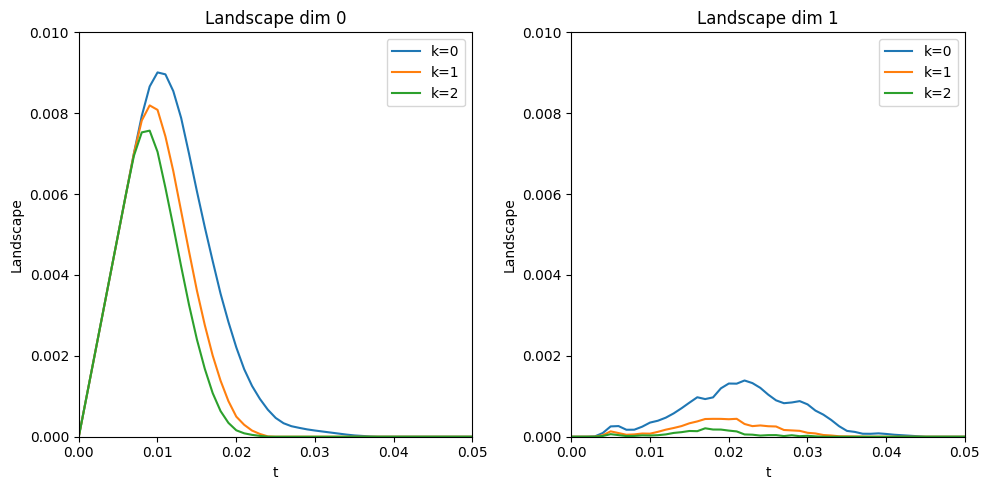

In [ ]:
method = "cluster"
mean_landscapes_alpha[15][method]["normal"].plot(limits=[0,0.05,0,0.01])
plt.tight_layout()
plt.savefig(f'../figures/cross_section_report/mean_landscape_alpha_{method}.png', dpi=300, bbox_inches='tight')

TypeError: 'list' object is not callable

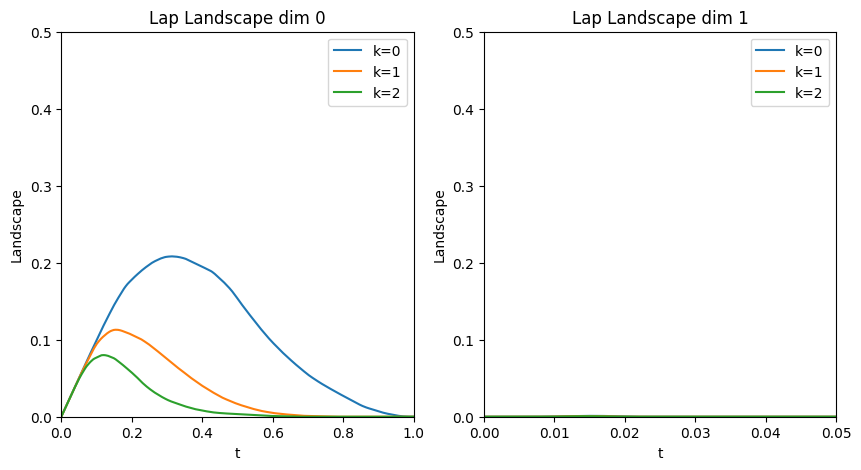

In [ ]:
method = "HC"
mean_landscapes_alpha[15][method]["laplacian"].plot(limits=[0,1, 0, 0.5])
plt.xlim(0, 0.05)
plt.ylim(0, 0.003)
plt.tight_layout()
# plt.savefig(f'../figures/cross_section_report/mean_lapland_alpha_{method}.png', dpi=300, bbox_inches='tight')

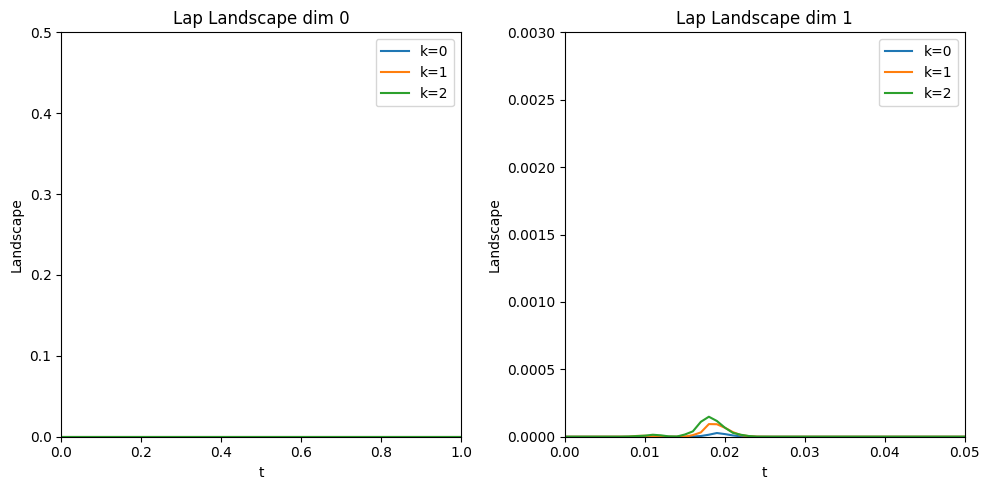

In [ ]:
method = "HC"
(mean_landscapes_alpha[15][method]["mtilde"]-mean_landscapes_alpha[15][method]["laplacian"]).plot(limits=[0,1, 0, 0.5])
plt.xlim(0, 0.05)
plt.ylim(0, 0.003)
plt.tight_layout()
# plt.savefig(f'../figures/cross_section_report/mean_lapland_alpha_Mdiff_{method}.png', dpi=300, bbox_inches='tight')

In [ ]:
classifications_dict_alpha = {}

methods = ["PV", "cluster", "HC"]
LL_test_alpha.reset_pointer()

for eps in LL_test_alpha.location_dict.keys():
    classifications_dict_alpha[eps] = {}
    method_bar = tqdm(LL_test_alpha.location_dict[eps]["alpha"].keys(), leave=False)
    for method in method_bar:
        classifications_dict_alpha[eps][method] = {}
        for type_ in ["laplacian", "normal", "mtilde"]:
            classifications_dict_alpha[eps][method][type_] = []
            method_bar.set_description(f"Processing landscapes for eps {eps}, method {method}, type {type_}")
            while True:
                cur_land = LL_test_alpha.load(eps, "alpha", method, type_)
                if cur_land is None:
                    break
                dists = []
                for other_method in methods:
                    mean_land = mean_landscapes_alpha[eps][other_method][type_]
                    dists.append((cur_land - mean_land).norm())
                classifications_dict_alpha[eps][method][type_].append(np.argmin(dists))

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import confusion_matrix

for type_ in ["laplacian", "normal", "mtilde"]:
    results = []
    y_true = []
    for method in methods:
        results += classifications_dict_alpha[15][method][type_]
        y_true += [methods.index(method)] * len(classifications_dict_alpha[15][method][type_])
    print(f"Confusion matrix for type {type_}:")
    cm = confusion_matrix(y_true, results, labels=list(range(len(methods))), normalize='true')
    print(cm)

Confusion matrix for type laplacian:
[[0.3  0.5  0.2 ]
 [0.15 0.6  0.25]
 [0.25 0.4  0.35]]
Confusion matrix for type normal:
[[0.7 0.  0.3]
 [0.  1.  0. ]
 [0.5 0.  0.5]]
Confusion matrix for type mtilde:
[[0.3  0.5  0.2 ]
 [0.15 0.6  0.25]
 [0.25 0.4  0.35]]


In [ ]:
LL_all_alpha = LandscapeLoader("../alpha_landscapes_normal_function/", "../alpha_landscapes/", [15])
feature_vector_dict_alpha = {}

y_target = [0]*100+[1]*100+[2]*97

LL_all_alpha.reset_pointer()
color = "alpha"

feature_vector_dict_alpha = {}
for type_ in ["laplacian", "normal", "mtilde"]:
    feature_vector_dict_alpha[type_] = []
    for method in tqdm(methods, desc=f"Processing eps {eps}, {color} feature vectors", leave=False):
        while True:
            cur_land = LL_all_alpha.load(eps, color, method, type_)
            if cur_land is None:
                break
            feature_vec = []
            for q in range(2):
                try:
                    evals = cur_land.sum_k().evaluations[q][0]
                except:
                    print(f"Error in loading landscape for eps {eps}, color {color}, method {method}, type {type_}")
                    # cur_land.plot()
                    # continue
                    raise ValueError
                feature_vec.append(evals[0:len(evals)-1:2])
            # print(np.hstack(feature_vec).shape)
            feature_vector_dict_alpha[type_].append(np.hstack(feature_vec))
    feature_vector_dict_alpha[type_] = np.vstack(feature_vector_dict_alpha[type_])

Processing eps 15, alpha HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, alpha HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, alpha PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 15, alpha feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 15, alpha feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print("type\t\tAccuracy on test set")
for type_ in ["laplacian", "normal", "mtilde"]:
    # print(f"{eps}\t{color[-1]}\t{type_}", end="\t\t")
    print(f"{type_}", end=" & ")
    X = feature_vector_dict_alpha[type_]
    y = np.array(y_target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    LR_model = LogisticRegression(max_iter=5000, random_state=42)
    LR_model.fit(X_train, y_train)
    print(f"{LR_model.score(X_test, y_test)*100:.1f}%")
    cm = confusion_matrix(y_test, LR_model.predict(X_test), labels=list(range(len(methods))), normalize='true')
    print(cm)

type		Accuracy on test set
laplacian & 68.3%
[[0.65 0.   0.35]
 [0.   0.95 0.05]
 [0.55 0.   0.45]]
normal & 65.0%
[[1.   0.   0.  ]
 [0.05 0.95 0.  ]
 [1.   0.   0.  ]]
mtilde & 68.3%
[[0.65 0.   0.35]
 [0.   0.95 0.05]
 [0.55 0.   0.45]]


BALL MAPPER
----------------

In [4]:
LL_train = LandscapeLoader("../ballmapper_landscapes_normal_function/", "../ballmapper_landscapes/", [15, 20, 25], max_image_i=80)
LL_test = LandscapeLoader("../ballmapper_landscapes_normal_function/", "../ballmapper_landscapes/", [15, 20, 25], min_image_i=80)
LL_all = LandscapeLoader("../ballmapper_landscapes_normal_function/", "../ballmapper_landscapes/", [15, 20, 25])

# LL_train_Mtilde = LandscapeLoader("../ballmapper_landscapes/", [15, 20, 25], max_image_i=80)
# LL_test_Mtilde = LandscapeLoader("../ballmapper_landscapes/", [15, 20, 25], min_image_i=80)

Processing eps 15, alpha HC landscapes:   0%|          | 0/384 [00:00<?, ?it/s]

Processing eps 15, alpha HC mtilde landscapes:   0%|          | 0/384 [00:00<?, ?it/s]

Processing eps 15, alpha PV landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha PV mtilde landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha cluster landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha cluster mtilde landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, gradient HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, random_124 HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, gradient HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, random_124 HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, gradient HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, random_124 HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha HC landscapes:   0%|          | 0/384 [00:00<?, ?it/s]

Processing eps 15, alpha HC mtilde landscapes:   0%|          | 0/384 [00:00<?, ?it/s]

Processing eps 15, alpha PV landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha PV mtilde landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha cluster landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha cluster mtilde landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, gradient HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, random_124 HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, gradient HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, random_124 HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, gradient HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, random_124 HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha HC landscapes:   0%|          | 0/384 [00:00<?, ?it/s]

Processing eps 15, alpha HC mtilde landscapes:   0%|          | 0/384 [00:00<?, ?it/s]

Processing eps 15, alpha PV landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha PV mtilde landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha cluster landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha cluster mtilde landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, gradient HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, random_124 HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, gradient HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, random_124 HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, gradient HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, random_124 HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Loading landscapes for eps=15, color=gradient, method=cluster, type=laplacian
Loading landscape 100


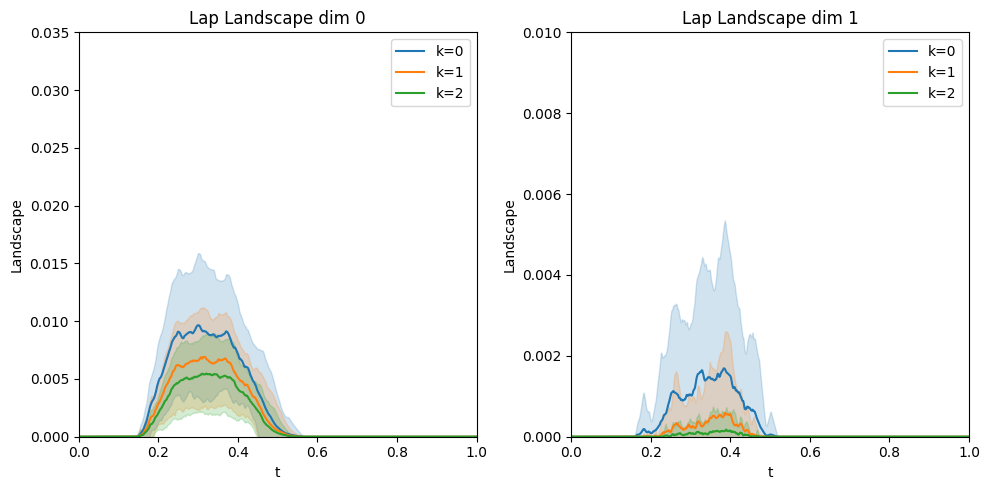

In [13]:
color = "gradient"
method = "cluster"

plot_mean_landscape(LL_all, 15, color=color, method=method, type_="laplacian", limits=[[0,1,0,0.035],[0,1,0,0.01]])
plt.savefig(f"../figures/cross_section_report/mean_landscape_conf_{color}_{method}_laplacian.png", bbox_inches='tight', dpi=300)

In [14]:
with open("cross_section_experiments_results_others.pkl", "rb") as f:
    out_dict = pickle.load(f)

In [ ]:
method_list = ["PV", "cluster", "HC"]
# out_dict = {}
for eps in [15, 20, 25]:
    # out_dict[eps] = {}
    for color in ["random_124", "gradient"]:
        # out_dict[eps][color] = {}
        for type_ in ["mtilde", "normal", "laplacian"]:
            # out_dict[eps][color][type_] = {}
            for method in method_list:
                # out_dict[eps][color][type_][method] = {}

                print(f"Gathering statistics for {type_} landscapes with method {method}, eps {eps} and color {color}\n"+"-"*20)

                LL_all.reset_pointer()

                sum_land = LL_all.load(eps, color, method, type_)
                counter = 1

                while True:
                    land = LL_all.load(eps, color, method, type_)
                    if land is None:
                        break
                    counter += 1
                    print(f"Loaded landscape {counter} for sum", end="\r")
                    sum_land += land

                loaded_landscapes = counter

                for dim in [0]:#[None, 1]:
                    out_dict[eps][color][type_][method][dim] = {}
                    LL_all.reset_pointer()
                    load_bar = tqdm(total= loaded_landscapes, desc = f"Dim {dim}, gathering statistics", leave = False)
                    dists = []

                    while True:
                        land = LL_all.load(eps, color, method, type_)
                        if land is None:
                            break
                        load_bar.update(1)
                        mean_land = (sum_land-land).__mult__(1/(loaded_landscapes-1))
                        dists.append((land - mean_land).norm(dim=dim))

                    load_bar.close()
                    out_dict[eps][color][type_][method][dim][method] = np.array(dists)

                    mean_land = sum_land.__mult__(1/loaded_landscapes)

                    for other_method in method_list:
                        if other_method == method:
                            continue
                        dists = []
                        load_bar = tqdm(total= loaded_landscapes, desc = f"Dim {dim}, comparison with {other_method[:2]}", leave = False)

                        while True:
                            land = LL_all.load(eps, color, other_method, type_)
                            if land is None:
                                break
                            load_bar.update(1)
                            dists.append((land - mean_land).norm(dim=dim))
                        load_bar.close()
                        out_dict[eps][color][type_][method][dim][other_method] = np.array(dists)

In [ ]:
# with open("cross_section_experiments_results_others.pkl", "wb") as f:
#     pickle.dump(out_dict, f)

In [19]:
method_list = ["PV", "cluster", "HC"]

print("eps\tcolor\ttype\tmethod\tdim\tpv.95\tcl.95\thc.95")
for method in method_list:
    for eps in [15, 20, 25]:
        for color in ["random_124", "gradient"]:
            for dim in [0, 1]:#[None, 1]:
                for type_ in ["normal", "laplacian", "mtilde"]:
                    print(f"{eps}\t{color[:5]}\t{type_[:5]}\t{method}\t{dim}", end="\t")
                    for alpha in [0.95]:
                        for other_method in method_list:
                            if other_method == method:
                                print("N/A", end="\t")
                            else:
                                print(np.round((out_dict[eps][color][type_][method][dim][other_method] > np.quantile(out_dict[eps][color][type_][method][dim][method], alpha)).mean(), 2), end="\t")
                    print()

eps	color	type	method	dim	pv.95	cl.95	hc.95
15	rando	norma	PV	0	N/A	0.45	0.07	
15	rando	lapla	PV	0	N/A	0.36	0.04	
15	rando	mtild	PV	0	N/A	0.36	0.03	
15	rando	norma	PV	1	N/A	0.24	0.04	
15	rando	lapla	PV	1	N/A	0.21	0.07	
15	rando	mtild	PV	1	N/A	0.21	0.07	
15	gradi	norma	PV	0	N/A	0.21	0.02	
15	gradi	lapla	PV	0	N/A	0.33	0.03	
15	gradi	mtild	PV	0	N/A	0.25	0.02	
15	gradi	norma	PV	1	N/A	0.18	0.06	
15	gradi	lapla	PV	1	N/A	0.4	0.06	
15	gradi	mtild	PV	1	N/A	0.4	0.06	
20	rando	norma	PV	0	N/A	0.37	0.06	
20	rando	lapla	PV	0	N/A	0.47	0.04	
20	rando	mtild	PV	0	N/A	0.49	0.04	
20	rando	norma	PV	1	N/A	0.26	0.06	
20	rando	lapla	PV	1	N/A	0.17	0.03	
20	rando	mtild	PV	1	N/A	0.17	0.03	
20	gradi	norma	PV	0	N/A	0.17	0.01	
20	gradi	lapla	PV	0	N/A	0.44	0.03	
20	gradi	mtild	PV	0	N/A	0.43	0.03	
20	gradi	norma	PV	1	N/A	0.16	0.01	
20	gradi	lapla	PV	1	N/A	0.38	0.06	
20	gradi	mtild	PV	1	N/A	0.38	0.06	
25	rando	norma	PV	0	N/A	0.26	0.06	
25	rando	lapla	PV	0	N/A	0.37	0.03	
25	rando	mtild	PV	0	N/A	0.42	0.04	
25	rando	norm

In [ ]:
mean_landscapes = {}
LL_train.reset_pointer()

for eps in LL_train.location_dict.keys():
    mean_landscapes[eps] = {}
    for color in LL_train.location_dict[eps].keys():
        if color == "alpha":
            continue
        mean_landscapes[eps][color] = {}
        method_bar = tqdm(LL_train.location_dict[eps][color].keys(), leave=False)
        for method in method_bar:
            mean_landscapes[eps][color][method] = {}
            for type_ in ["laplacian", "normal", "mtilde"]:
                cur_lands = []
                i = 0
                while True:
                    method_bar.set_description(f"Processing landscapes for eps {eps}, color {color}, method {method}, type {type_}, i {i}")
                    land = LL_train.load(eps, color, method, type_)
                    if land is None:
                        break
                    cur_lands.append(land)
                    i += 1
                mean_landscapes[eps][color][method][type_] = np.mean(cur_lands)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# with open("../ballmapper_landscapes_normal_function/mean_landscapes.pkl", "wb") as f:
#     pickle.dump(mean_landscapes, f)

In [5]:
with open("../ballmapper_landscapes_normal_function/mean_landscapes.pkl", "rb") as f:
    mean_landscapes = pickle.load(f)

# with open("../ballmapper_landscapes/mean_landscapes.pkl", "rb") as f:
#     mean_landscapes_Mtilde = pickle.load(f)

array([<Axes: title={'center': 'Landscape dim 0'}, xlabel='t', ylabel='Landscape'>,
       <Axes: title={'center': 'Landscape dim 1'}, xlabel='t', ylabel='Landscape'>],
      dtype=object)

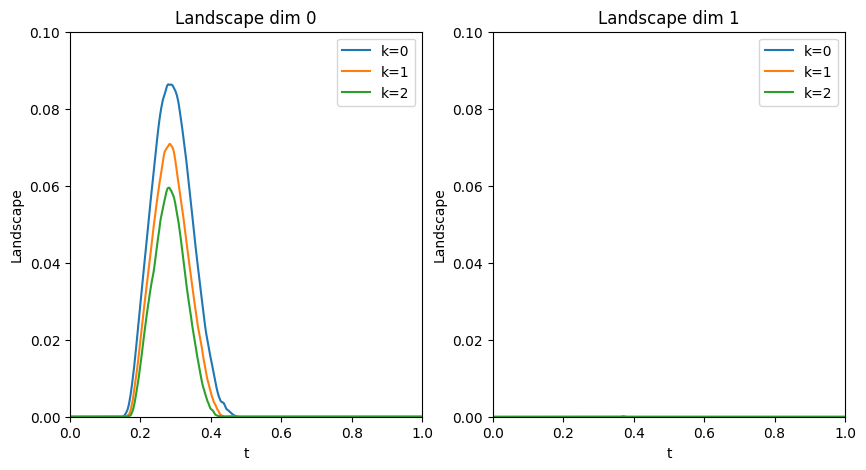

In [6]:
mean_landscapes[15]["random_124"]["HC"]["normal"].plot(limits = [0, 1, 0, 0.1])

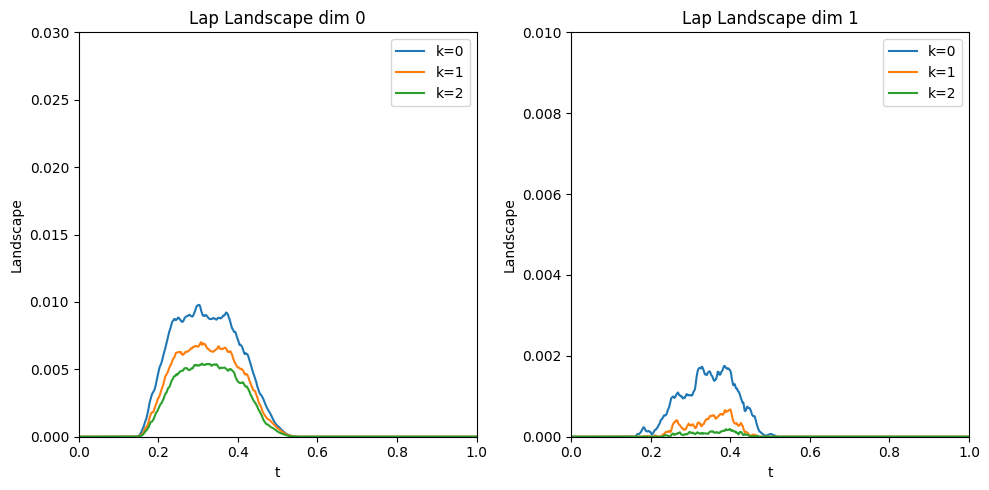

In [21]:
method = "cluster"
color = "gradient"
mean_landscapes[15][color][method]["laplacian"].plot(limits = [0, 1, 0, 0.03])
plt.ylim(0, 0.01)
plt.tight_layout()
plt.savefig(f'../figures/cross_section_report/mean_lapland_{color}_{method}.png', dpi=300, bbox_inches='tight')

# (mean_landscapes[15]["random_124"][method]["mtilde"]-mean_landscapes[15]["random_124"][method]["laplacian"]).plot(limits = [0, 1, 0, 0.05])

In [11]:
classifications_dict = {}

methods = ["PV", "cluster", "HC"]

LL_test.reset_pointer()

for eps in LL_test.location_dict.keys():
    classifications_dict[eps] = {}
    for color in LL_test.location_dict[eps].keys():
        if color == "alpha":
            continue
        # if color == "gradient" and eps == 15:
        #     continue
        classifications_dict[eps][color] = {}
        method_bar = tqdm(LL_test.location_dict[eps][color].keys(), leave=False)
        for method in method_bar:
            classifications_dict[eps][color][method] = {}
            for type_ in ["laplacian", "normal", "mtilde"]:
                classifications_dict[eps][color][method][type_] = []
                method_bar.set_description(f"Processing landscapes for eps {eps}, color {color}, method {method}, type {type_}")
                while True:
                    cur_land = LL_test.load(eps, color, method, type_)
                    if cur_land is None:
                        break
                    dists = []
                    for other_method in methods:
                        mean_land = mean_landscapes[eps][color][other_method][type_]
                        dists.append((cur_land - mean_land).norm())
                    classifications_dict[eps][color][method][type_].append(np.argmin(dists))

# for eps in LL_train.location_dict.keys():
#     classifications_dict[eps] = {}
#     for color in LL_train.location_dict[eps].keys():
#         if color == "alpha":
#             continue
#         classifications_dict[eps][color] = {}
#         method_bar = tqdm(LL_train.location_dict[eps][color].keys(), leave=False)
#         for method in method_bar:
#             classifications_dict[eps][color][method] = {}
#             for type_ in ["laplacian", "normal", "both"]:
#                 classifications_dict[eps][color][method][type_] = []
#             method_bar.set_description(f"Processing landscapes for eps {eps}, color {color}, method {method}")
#             while True:
#                 cur_land_pers = LL_train.load(eps, color, method, "normal")
#                 cur_land_lap = LL_train.load(eps, color, method, "laplacian")
#                 if cur_land_pers is None:
#                     break
#                 dists_pers = []
#                 dists_lap = []
#                 for other_method in methods:
#                     mean_land_pers = mean_landscapes[eps][color][other_method]["normal"]
#                     mean_land_lap = mean_landscapes[eps][color][other_method]["laplacian"]
#                     dists_pers.append((cur_land_pers - mean_land_pers).norm())
#                     dists_lap.append((cur_land_lap - mean_land_lap).norm())
#                 # print(f"type: {type_}, min dists: {np.min(dists)}, max dists: {np.max(dists)}, mean dists: {np.mean(dists)}")
#                 classifications_dict[eps][color][method]["normal"].append(np.argmin(dists_pers))
#                 classifications_dict[eps][color][method]["laplacian"].append(np.argmin(dists_lap))
#                 dists_both = (np.array(dists_pers)-np.min(dists_pers))/(np.max(dists_pers)-np.min(dists_pers)) + (np.array(dists_lap)-np.min(dists_lap))/(np.max(dists_lap)-np.min(dists_lap))
#                 classifications_dict[eps][color][method]["both"].append(np.argmin(dists_both))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
with open("../ballmapper_landscapes_normal_function/classifications_dict.pkl", "wb") as f:
    pickle.dump(classifications_dict, f)

In [22]:
from sklearn.metrics import f1_score

print(f"eps\tcolor\t\tType\t\t\tAccuracy\tf1-score\t{methods[0]} acc\t\t{methods[1]} acc\t{methods[2]} acc")
for eps in [15, 20, 25]:
    for color in ["gradient", "random_124"]:
        # if eps == 15 and color == "gradient":
        #     continue
        for type_ in ["normal", "laplacian",  "mtilde"]:
            results = np.array([])
            y = np.array([])
            acc_methods = []
            for method in methods:
                cur_results = np.array(classifications_dict[eps][color][method][type_])
                results = np.append(results, cur_results)
                y = np.append(y, np.ones_like(cur_results) * methods.index(method))
                acc_methods.append(np.mean(cur_results==np.ones_like(cur_results) * methods.index(method)))
            # if eps == 15 and color == "random_124":
            #     print(cur_results)

            print(f"{eps}\t{color}\t{type_[:6]}", end="\t\t\t")
            print(f"{np.mean(results==y)*100:.1f}%\t\t{f1_score(y, results, average='weighted'):.3f}", end="\t\t")
            print(f"{acc_methods[0]*100:.1f}%\t\t{acc_methods[1]*100:.1f}%\t\t{acc_methods[2]*100:.1f}%")
            # np.mean(results==y), np.std(results==y)

eps	color		Type			Accuracy	f1-score	PV acc		cluster acc	HC acc
15	gradient	normal			50.0%		0.507		45.0%		45.0%		60.0%
15	gradient	laplac			46.7%		0.483		35.0%		60.0%		45.0%
15	gradient	mtilde			43.3%		0.440		25.0%		60.0%		45.0%
15	random_124	normal			56.7%		0.558		35.0%		80.0%		55.0%
15	random_124	laplac			58.3%		0.581		45.0%		55.0%		75.0%
15	random_124	mtilde			60.0%		0.596		45.0%		55.0%		80.0%
20	gradient	normal			51.7%		0.521		60.0%		40.0%		55.0%
20	gradient	laplac			40.0%		0.419		25.0%		55.0%		40.0%
20	gradient	mtilde			43.3%		0.451		30.0%		60.0%		40.0%
20	random_124	normal			48.3%		0.481		35.0%		60.0%		50.0%
20	random_124	laplac			51.7%		0.529		40.0%		60.0%		55.0%
20	random_124	mtilde			53.3%		0.546		40.0%		60.0%		60.0%
25	gradient	normal			50.0%		0.504		65.0%		40.0%		45.0%
25	gradient	laplac			48.3%		0.487		60.0%		55.0%		30.0%
25	gradient	mtilde			51.7%		0.518		60.0%		65.0%		30.0%
25	random_124	normal			43.3%		0.427		25.0%		65.0%		40.0%
25	random_124	laplac			43.3%		0.441		20.0%	

In [29]:
LL_all = LandscapeLoader("../ballmapper_landscapes_normal_function/", "../ballmapper_landscapes/", [15, 20, 25])
feature_vector_dict = {}

y_target = [0]*100+[1]*100+[2]*97

LL_all.reset_pointer()

for eps in [15, 20, 25]:
    feature_vector_dict[eps] = {}
    for color in ["gradient", "random_124"]:
        feature_vector_dict[eps][color] = {}
        for type_ in ["laplacian", "normal", "mtilde"]:
            feature_vector_dict[eps][color][type_] = []
            for method in tqdm(methods, desc=f"Processing eps {eps}, {color} feature vectors", leave=False):
                while True:
                    cur_land = LL_all.load(eps, color, method, type_)
                    if cur_land is None:
                        break
                    feature_vec = []
                    for q in range(2):
                        try:
                            evals = cur_land.sum_k().evaluations[q][0]
                        except:
                            print(f"Error in loading landscape for eps {eps}, color {color}, method {method}, type {type_}")
                            # cur_land.plot()
                            # continue
                            raise ValueError
                        feature_vec.append(evals[0:len(evals)-1:2])
                    # print(np.hstack(feature_vec).shape)
                    feature_vector_dict[eps][color][type_].append(np.hstack(feature_vec))
            feature_vector_dict[eps][color][type_] = np.vstack(feature_vector_dict[eps][color][type_])

Processing eps 15, alpha HC landscapes:   0%|          | 0/384 [00:00<?, ?it/s]

Processing eps 15, alpha HC mtilde landscapes:   0%|          | 0/384 [00:00<?, ?it/s]

Processing eps 15, alpha PV landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha PV mtilde landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha cluster landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha cluster mtilde landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, gradient HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, random_124 HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, gradient HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, random_124 HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, gradient HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, random_124 HC mtilde landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 PV mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 cluster mtilde landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 15, gradient feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 15, gradient feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 15, random_124 feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 15, random_124 feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 15, random_124 feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 20, gradient feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 20, gradient feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 20, gradient feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 20, random_124 feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 20, random_124 feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 20, random_124 feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 25, gradient feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 25, gradient feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 25, gradient feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 25, random_124 feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 25, random_124 feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

Processing eps 25, random_124 feature vectors:   0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
with open("../ballmapper_landscapes_normal_function/feature_vector_dict.pkl", "wb") as f:
    pickle.dump(feature_vector_dict, f)

In [35]:
from sklearn.metrics import confusion_matrix

print("type\t\tAccuracy on test set")
for eps in [15, 20, 25]:
    for color in ["gradient", "random_124"]:
        for type_ in ["normal","laplacian", "mtilde"]:
            # print(f"{eps}\t{color[-1]}\t{type_}", end="\t\t")
            print(f"{eps}\t{color}\t{type_[:5]}", end="\t\t")
            X = feature_vector_dict[eps][color][type_]
            y = np.array(y_target)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
            LR_model = LogisticRegression(max_iter=5000, random_state=42)
            LR_model.fit(X_train, y_train)
            print(f"{LR_model.score(X_test, y_test)*100:.1f}%", end="\t")
            cm = confusion_matrix(y_test, LR_model.predict(X_test), labels=list(range(len(methods))), normalize='true')
            print(f"{cm[0,0]*100:.1f}%\t{cm[1,1]*100:.1f}%\t{cm[2,2]*100:.1f}%")

type		Accuracy on test set
15	gradient	norma		50.0%	60.0%	75.0%	15.0%
15	gradient	lapla		33.3%	35.0%	45.0%	20.0%
15	gradient	mtild		40.0%	30.0%	55.0%	35.0%
15	random_124	norma		56.7%	35.0%	90.0%	45.0%
15	random_124	lapla		63.3%	50.0%	80.0%	60.0%
15	random_124	mtild		55.0%	25.0%	80.0%	60.0%
20	gradient	norma		51.7%	75.0%	80.0%	0.0%
20	gradient	lapla		40.0%	45.0%	50.0%	25.0%
20	gradient	mtild		40.0%	30.0%	60.0%	30.0%
20	random_124	norma		56.7%	40.0%	90.0%	40.0%
20	random_124	lapla		61.7%	55.0%	85.0%	45.0%
20	random_124	mtild		61.7%	55.0%	85.0%	45.0%
25	gradient	norma		51.7%	70.0%	80.0%	5.0%
25	gradient	lapla		50.0%	70.0%	45.0%	35.0%
25	gradient	mtild		50.0%	60.0%	60.0%	30.0%
25	random_124	norma		60.0%	55.0%	90.0%	35.0%
25	random_124	lapla		53.3%	35.0%	90.0%	35.0%
25	random_124	mtild		51.7%	35.0%	85.0%	35.0%
